# NPM Supply Chain Network Analysis
## Automated Analysis Pipeline

This notebook performs a comprehensive analysis of the NPM supply chain network. It executes the following steps:
1.  **Data Acquisition**: Fetches the most dependent packages from `ecosyste.ms`.
2.  **Network Construction**: Builds a dependency graph using `networkx`.
3.  **Risk Assessment**: Calculates centrality metrics and a composite **Behavioral Risk Score (BRS)**.
4.  **Robustness Simulation**: Simulates targeted and random attacks to evaluate network resilience.
5.  **Visualization**: Generates plots for network topology, degree distributions, and simulation results.
6.  **Strategic Insights**: Analyzes risk components and ecosystem relationships.
7.  **Validation**: Validates the BRS model against cascade impact simulations.
8.  **Export**: Saves results for external analysis.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import sys
import os
import numpy as np

# --- Path Setup ---
# Add current directory and parent directory to path to ensure imports work
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

if current_dir not in sys.path:
    sys.path.append(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# --- Import Custom Modules ---
try:
    from data_loader import get_combined_seed_packages
    from network_builder import build_dependency_graph
    from metrics import calculate_risk_scores
    from simulation import simulate_attacks, calculate_single_node_impact
    from utils import export_results
    from visualize import (
        plot_network_structure, 
        plot_degree_distributions, 
        plot_correlations, 
        plot_top_risk_scores, 
        plot_simulation_results,
        plot_risk_vs_cascade,
        plot_metric_heatmap, 
        plot_brs_components, 
        plot_ecosystem_vs_network, 
        plot_risk_distribution_by_type,
        plot_brs_vs_cascade_validation, 
        plot_brs_distribution, 
        plot_top20_brs_component_lines,
        plot_brs_vs_global_reach
    )
except ImportError as e:
    print(f"Error importing modules: {e}")
    print("Please ensure you are running this notebook from the 'analysis' directory.")

# --- Configuration ---
TOP_N = 1000              # Number of seed packages to fetch (per category)
MAX_DEPTH = 7             # Traversal depth for the crawler
BETWEENNESS_K = 100       # Sampling size for faster betweenness calculation
API_DELAY = 0.1           # Delay between API calls in seconds
OUTPUT_DIR = '../results' # Output directory
FORCE_RERUN = False       # Set to True to force re-crawling and re-calculation

# Simulation Config
SIMULATION_REMOVALS = 500 # Number of nodes to remove in robustness simulation
IMPACT_SAMPLE_SIZE = 100  # Number of top nodes to analyze for cascade impact

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'plots'), exist_ok=True)

# --- Visualization Setup ---
sns.set_theme(style="whitegrid", context="notebook", palette="deep")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Environment setup complete. Configuration loaded.")

Environment setup complete. Configuration loaded.


## 2. Data Acquisition
We fetch the top `TOP_N` packages sorted by both **dependents** and **downloads** from the `ecosyste.ms` API. These packages serve as the "seed" nodes for our network crawler.

Using a combined strategy ensures we capture both:
1.  **Infrastructure Giants**: Packages that other packages depend on (High Dependents).
2.  **End-User Tools**: Packages that developers use directly (High Downloads).

In [2]:
# Fetch seed packages (Combined Strategy)
graph_file = os.path.join(OUTPUT_DIR, "network.gml")

if os.path.exists(graph_file) and not FORCE_RERUN:
    print(f"Found existing graph at {graph_file}. Skipping seed fetch (Data Acquisition step).")
    print("Will load graph from disk in the next step.")
else:
    seed_packages = get_combined_seed_packages(limit_dependents=TOP_N, limit_downloads=TOP_N, api_delay=API_DELAY)
    print(f"Total unique seed packages: {len(seed_packages)}")

Fetching top 1000 packages by DEPENDENTS from ecosyste.ms...


Fetching Dependent Seeds:   0%|          | 0/1000 [00:00<?, ?it/s]

Fetching top 1000 packages by DOWNLOADS from ecosyste.ms...


Fetching Download Seeds:   0%|          | 0/1000 [00:00<?, ?it/s]

Merging lists and removing duplicates...
Total unique seed packages: 1452
Total unique seed packages: 1452


## 3. Network Construction
Using the seed packages, we build a directed dependency graph. The crawler traverses dependencies up to `MAX_DEPTH`.
- **Nodes**: Packages
- **Edges**: Directed dependencies (Package A depends on Package B)


In [3]:
# Build Graph or Load from Disk
graph_file = os.path.join(OUTPUT_DIR, "network.gml")
graph_loaded = False

if os.path.exists(graph_file) and not FORCE_RERUN:
    print(f"Found existing graph at {graph_file}. Loading...")
    try:
        G = nx.read_gml(graph_file)
        if len(G) > 0:
            graph_loaded = True
        else:
            print("Loaded graph is empty. Will re-build.")
    except Exception as e:
        print(f"Error loading graph: {e}. Will re-build.")

if not graph_loaded:
    print("Starting network crawler (this may take a while)...")
    
    # Only fetch seeds if we need to crawl
    if 'seed_packages' not in locals():
        print("Fetching seed packages...")
        seed_packages = get_combined_seed_packages(limit_dependents=TOP_N, limit_downloads=TOP_N, api_delay=API_DELAY)
        print(f"Total unique seed packages: {len(seed_packages)}")
    
    G = build_dependency_graph(seed_packages, max_depth=MAX_DEPTH, api_delay=API_DELAY)
    
    # Save immediately after building
    print(f"Saving graph to {graph_file}...")
    nx.write_gml(G, graph_file)
    print("Graph saved.")

# Ensure G is available for subsequent cells
if 'G' not in locals():
    raise RuntimeError("Failed to initialize Graph G.")

Starting network crawler (this may take a while)...
Starting crawler with 1452 seed packages up to depth 7...


Crawling Dependencies: 0it [00:00, ?it/s]

Graph construction complete. Nodes: 2183, Edges: 5417
Saving graph to ../results\network.gml...
Graph saved.


In [4]:
# Print Graph Statistics
print(f"Graph Statistics:")
print(f" - Nodes: {G.number_of_nodes()}")
print(f" - Edges: {G.number_of_edges()}")
print(f" - Density: {nx.density(G):.6f}")
print(f" - Is Strongly Connected: {nx.is_strongly_connected(G)}")
print(f" - Is Weakly Connected: {nx.is_weakly_connected(G)}")


Graph Statistics:
 - Nodes: 2183
 - Edges: 5417
 - Density: 0.001137
 - Is Strongly Connected: False
 - Is Weakly Connected: False


## 4. Metrics & Risk Scoring
We calculate centrality metrics and a composite **Topology-Weighted Risk Score (BRS)** to identify critical nodes. Based on validation results, this formula heavily weights the metrics most responsible for network fragmentation.

### Core Metrics Used:
- **Betweenness Centrality (50%):** The most critical metric, measuring a package's role as a 'bridge' for information and risk flow.
- **In-Degree (30%):** Represents a package's direct impact and popularity as a dependency hub within our graph.
- **Out-Degree (10%):** Quantifies the complexity and potential attack surface a package introduces.
- **Dependents Count (5%):** A measure of global popularity across the entire NPM ecosystem.
- **Downloads (5%):** A proxy for overall adoption and usage intensity.

### The Topology-Weighted Risk Score (BRS) Formula
All metrics are Min-Max normalized before the calculation. Highly skewed metrics like 'Dependents' and 'Downloads' are log-normalized first to ensure a balanced score.

$$ \text{BRS} = (0.50 \cdot \text{Betweenness}') + (0.30 \cdot \text{InDegree}') + (0.10 \cdot \text{OutDegree}') + (0.05 \cdot \text{Dependents}') + (0.05 \cdot \text{Downloads}')$$

This model is designed to be a direct predictor of systemic risk by focusing on the topological drivers of cascade effects.

In [5]:
# Calculate Metrics or Load from Disk
risk_file = os.path.join(OUTPUT_DIR, "risk_scores.csv")
metrics_loaded = False

# We should re-calculate metrics if we forced a re-run OR if the graph was just re-built (not loaded)
should_recalc = FORCE_RERUN or (not graph_loaded)

if os.path.exists(risk_file) and not should_recalc:
    print(f"Found existing risk scores at {risk_file}. Loading...")
    try:
        risk_df = pd.read_csv(risk_file)
        
        # Basic validation
        if 'package' not in risk_df.columns and 'name' in risk_df.columns:
            risk_df = risk_df.rename(columns={'name': 'package'})
            
        if len(risk_df) > 0:
            print(f"Risk scores loaded successfully ({len(risk_df)} packages).")
            metrics_loaded = True
        else:
            print("Risk scores file is empty.")
    except Exception as e:
        print(f"Error loading risk scores: {e}")

if not metrics_loaded:
    print("Calculating metrics (this may take a moment)...")
    risk_df = calculate_risk_scores(G, betweenness_k=BETWEENNESS_K)
    
    # Save immediately
    print(f"Saving risk scores to {risk_file}...")
    risk_df.to_csv(risk_file, index=False)
    print("Risk scores saved.")

print("\nTop 10 Critical Packages:")
display(risk_df.head(10))

Calculating metrics (this may take a moment)...
Calculating network metrics...
Approximating betweenness centrality (k=100)...
Calculating clustering coefficient...
Detecting communities (Louvain)...
Calculating clustering coefficient...
Detecting communities (Louvain)...
Saving risk scores to ../results\risk_scores.csv...
Risk scores saved.

Top 10 Critical Packages:
Saving risk scores to ../results\risk_scores.csv...
Risk scores saved.

Top 10 Critical Packages:


,package,risk_score,community_group,in_degree,out_degree,betweenness,clustering,dependents_count,downloads,staleness_days,maintainer_risk,in_degree_norm,out_degree_norm,betweenness_norm,dependents_count_norm,downloads_norm,staleness_norm,clustering_risk_norm,type,rank
1112,es-abstract,0.669142,149,17,54,0.000369,0.036246,6024,237925500,191,1.000,0.108974,0.650602,1.000000,0.559098,0.868683,0.730013,0.963754,seed,1878
736,tslib,0.394468,184,156,0,0.000000,0.050993,1726336,1200303589,38,0.125,1.000000,0.000000,0.000000,0.922541,0.966825,0.508693,0.949007,seed,737
427,get-intrinsic,0.379901,149,22,10,0.000172,0.090726,2347505,374205713,66,1.000,0.141026,0.120482,0.467247,0.942284,0.896145,0.583830,0.909274,seed,428
140,@babel/core,0.341746,19,12,15,0.000153,0.045584,3617515,314302543,43,0.250,0.076923,0.180723,0.415630,0.970062,0.885565,0.525442,0.954416,seed,141
446,side-channel,0.333893,149,4,5,0.000170,0.138889,2287311,209378386,359,1.000,0.025641,0.060241,0.460199,0.940615,0.860932,0.817297,0.861111,seed,447
523,qs,0.332493,126,8,1,0.000165,0.013889,2110964,433089113,325,0.500,0.051282,0.012048,0.447761,0.935461,0.905007,0.803522,0.986111,seed,524
1349,jest-circus,0.326522,127,1,20,0.000158,0.095238,1237144,126378250,69,0.200,0.006410,0.240964,0.427861,0.901137,0.830315,0.589912,0.904762,seed,1040
599,jest-runner,0.305759,127,2,22,0.000138,0.139493,1982094,141312061,69,0.200,0.012821,0.265060,0.373964,0.931415,0.837089,0.589912,0.860507,seed,600
525,babel-jest,0.304554,127,2,7,0.000150,0.097222,2106569,166767023,69,0.200,0.012821,0.084337,0.406302,0.935328,0.847133,0.589912,0.902778,seed,526
148,@babel/helper-plugin-utils,0.304110,19,110,0,0.000000,0.007506,3527362,301252249,43,0.250,0.705128,0.000000,0.000000,0.968441,0.882994,0.525442,0.992494,seed,149


## 5. Robustness Simulation
We simulate supply chain attacks by removing nodes and measuring the network's fragmentation.
- **Targeted Attack**: Removing nodes with the highest BRS.
- **Random Attack**: Removing random nodes.
- **Metric**: Size of the Largest Connected Component (LCC). A faster decay in LCC indicates higher vulnerability.

We also calculate the **Cascade Impact** for the top risky nodes, defined as the reduction in LCC size when that single node is removed.


In [6]:
# Run Simulations or Load from Disk
sim_results_file = os.path.join(OUTPUT_DIR, "sim_results.csv")
impact_results_file = os.path.join(OUTPUT_DIR, "impact_scores.csv")

# --- 1. Robustness Simulation ---
if os.path.exists(sim_results_file) and not FORCE_RERUN:
    print(f"Loading simulation results from {sim_results_file}...")
    sim_results = pd.read_csv(sim_results_file)
else:
    print(f"Running robustness simulations (Removals: {SIMULATION_REMOVALS})...")
    if 'G' not in locals() or 'risk_df' not in locals():
        raise RuntimeError("G or risk_df missing. Cannot run simulation.")
        
    sim_results = simulate_attacks(G, risk_df, num_removals=SIMULATION_REMOVALS)
    sim_results.to_csv(sim_results_file, index=False)
    print(f"Simulation results saved to {sim_results_file}")

# --- 2. Cascade Impact Analysis ---
if os.path.exists(impact_results_file) and not FORCE_RERUN:
    print(f"Loading cascade impact results from {impact_results_file}...")
    impact_df = pd.read_csv(impact_results_file)
else:
    print(f"Calculating cascade impact for top {IMPACT_SAMPLE_SIZE} nodes...")
    if 'G' not in locals() or 'risk_df' not in locals():
        raise RuntimeError("G or risk_df missing. Cannot calculate impact.")
        
    impact_df = calculate_single_node_impact(G, risk_df, sample_size=IMPACT_SAMPLE_SIZE)
    impact_df.to_csv(impact_results_file, index=False)
    print(f"Cascade impact results saved to {impact_results_file}")

print("\nTop 5 Packages by Cascade Impact:")
if impact_df is not None and not impact_df.empty:
    display(impact_df.head(5))
else:
    print("No impact data available.")

Running robustness simulations (Removals: 500)...
Running simulations (Targeted vs Random) for 500 steps...


Targeted Attack:   0%|          | 0/500 [00:00<?, ?it/s]

Running 5 random simulations to average...
Simulation results saved to ../results\sim_results.csv
Calculating cascade impact for top 100 nodes...
Calculating single-node cascade impact for top 100 nodes...
Simulation results saved to ../results\sim_results.csv
Calculating cascade impact for top 100 nodes...
Calculating single-node cascade impact for top 100 nodes...


Impact Analysis:   0%|          | 0/100 [00:00<?, ?it/s]

Cascade impact results saved to ../results\impact_scores.csv

Top 5 Packages by Cascade Impact:


,package,risk_score,community_group,in_degree,out_degree,betweenness,clustering,dependents_count,downloads,staleness_days,...,in_degree_norm,out_degree_norm,betweenness_norm,dependents_count_norm,downloads_norm,staleness_norm,clustering_risk_norm,type,rank,cascade_impact
1112,es-abstract,0.669142,149,17,54,0.000369,0.036246,6024,237925500,191,...,0.108974,0.650602,1.000000,0.559098,0.868683,0.730013,0.963754,seed,1878,2
736,tslib,0.394468,184,156,0,0.000000,0.050993,1726336,1200303589,38,...,1.000000,0.000000,0.000000,0.922541,0.966825,0.508693,0.949007,seed,737,3
427,get-intrinsic,0.379901,149,22,10,0.000172,0.090726,2347505,374205713,66,...,0.141026,0.120482,0.467247,0.942284,0.896145,0.583830,0.909274,seed,428,1
140,@babel/core,0.341746,19,12,15,0.000153,0.045584,3617515,314302543,43,...,0.076923,0.180723,0.415630,0.970062,0.885565,0.525442,0.954416,seed,141,2
446,side-channel,0.333893,149,4,5,0.000170,0.138889,2287311,209378386,359,...,0.025641,0.060241,0.460199,0.940615,0.860932,0.817297,0.861111,seed,447,1


## 6. Core Network Metrics
Here we visualize the fundamental structure of the network and the distribution of node degrees.
- **Network Topology**: A visual representation of the graph (sampled if too large).
- **Degree Distributions**: Histograms showing In-Degree and Out-Degree distributions (typically power-law).
- **Correlations**: A scatter matrix showing relationships between different risk metrics.
- **Top Risk Scores**: A bar chart of the packages with the highest BRS.

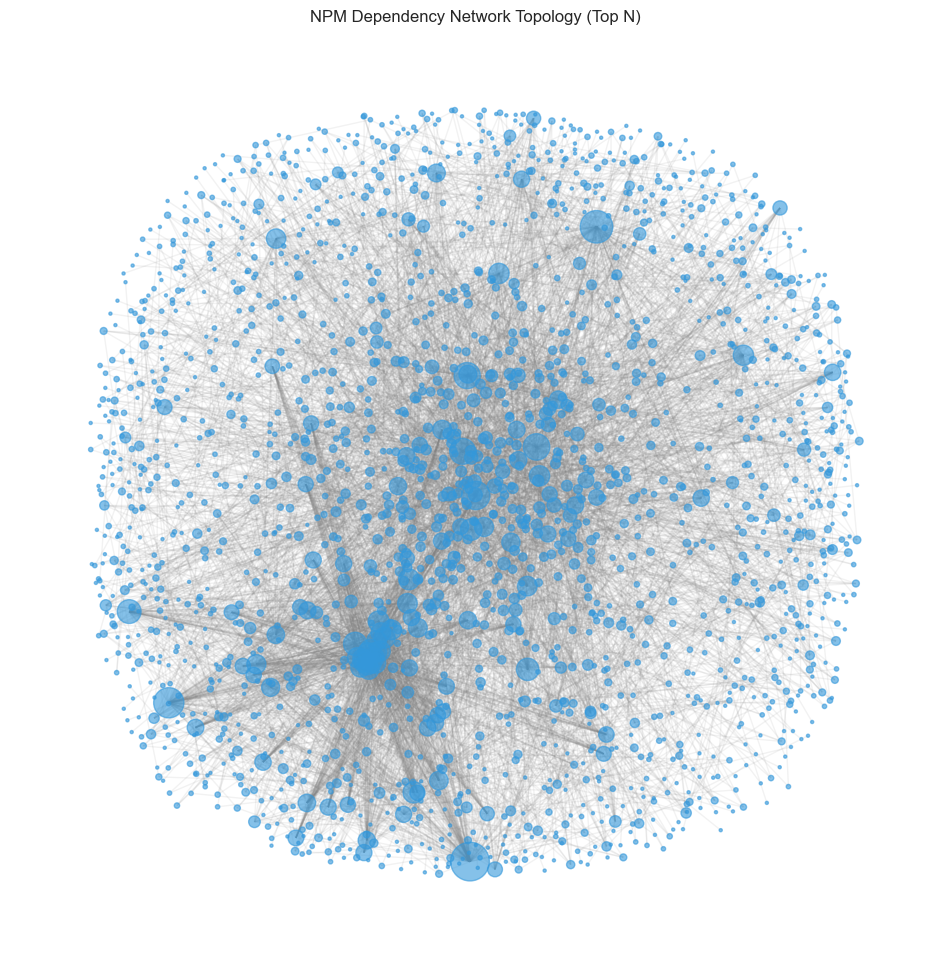

 - Saved ../results/plots/network_full_topN.png


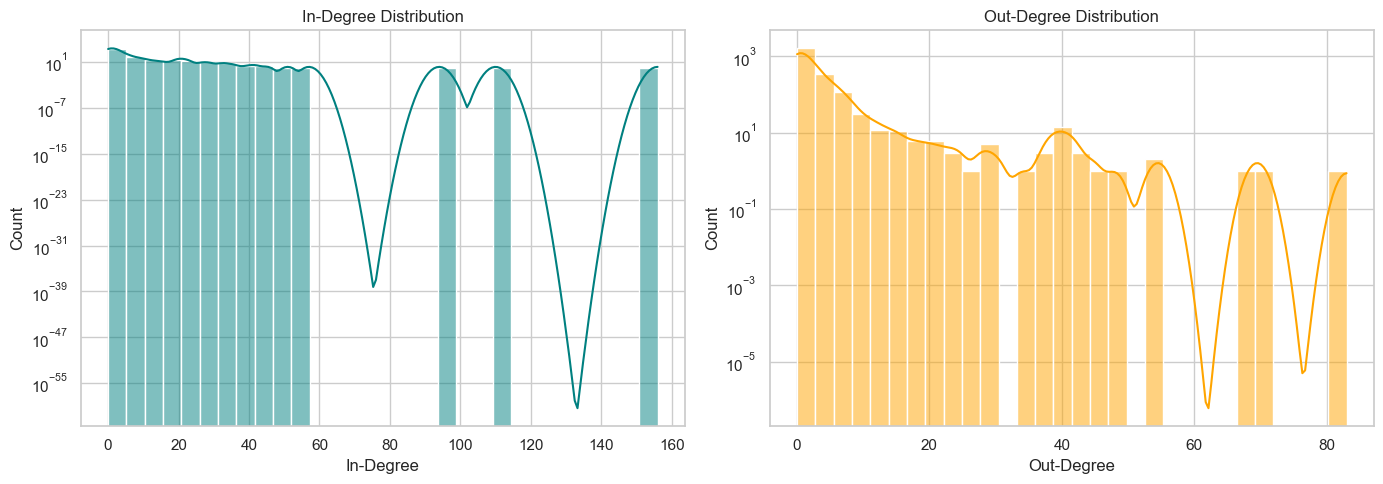

 - Saved ../results/plots/degree_histograms.png


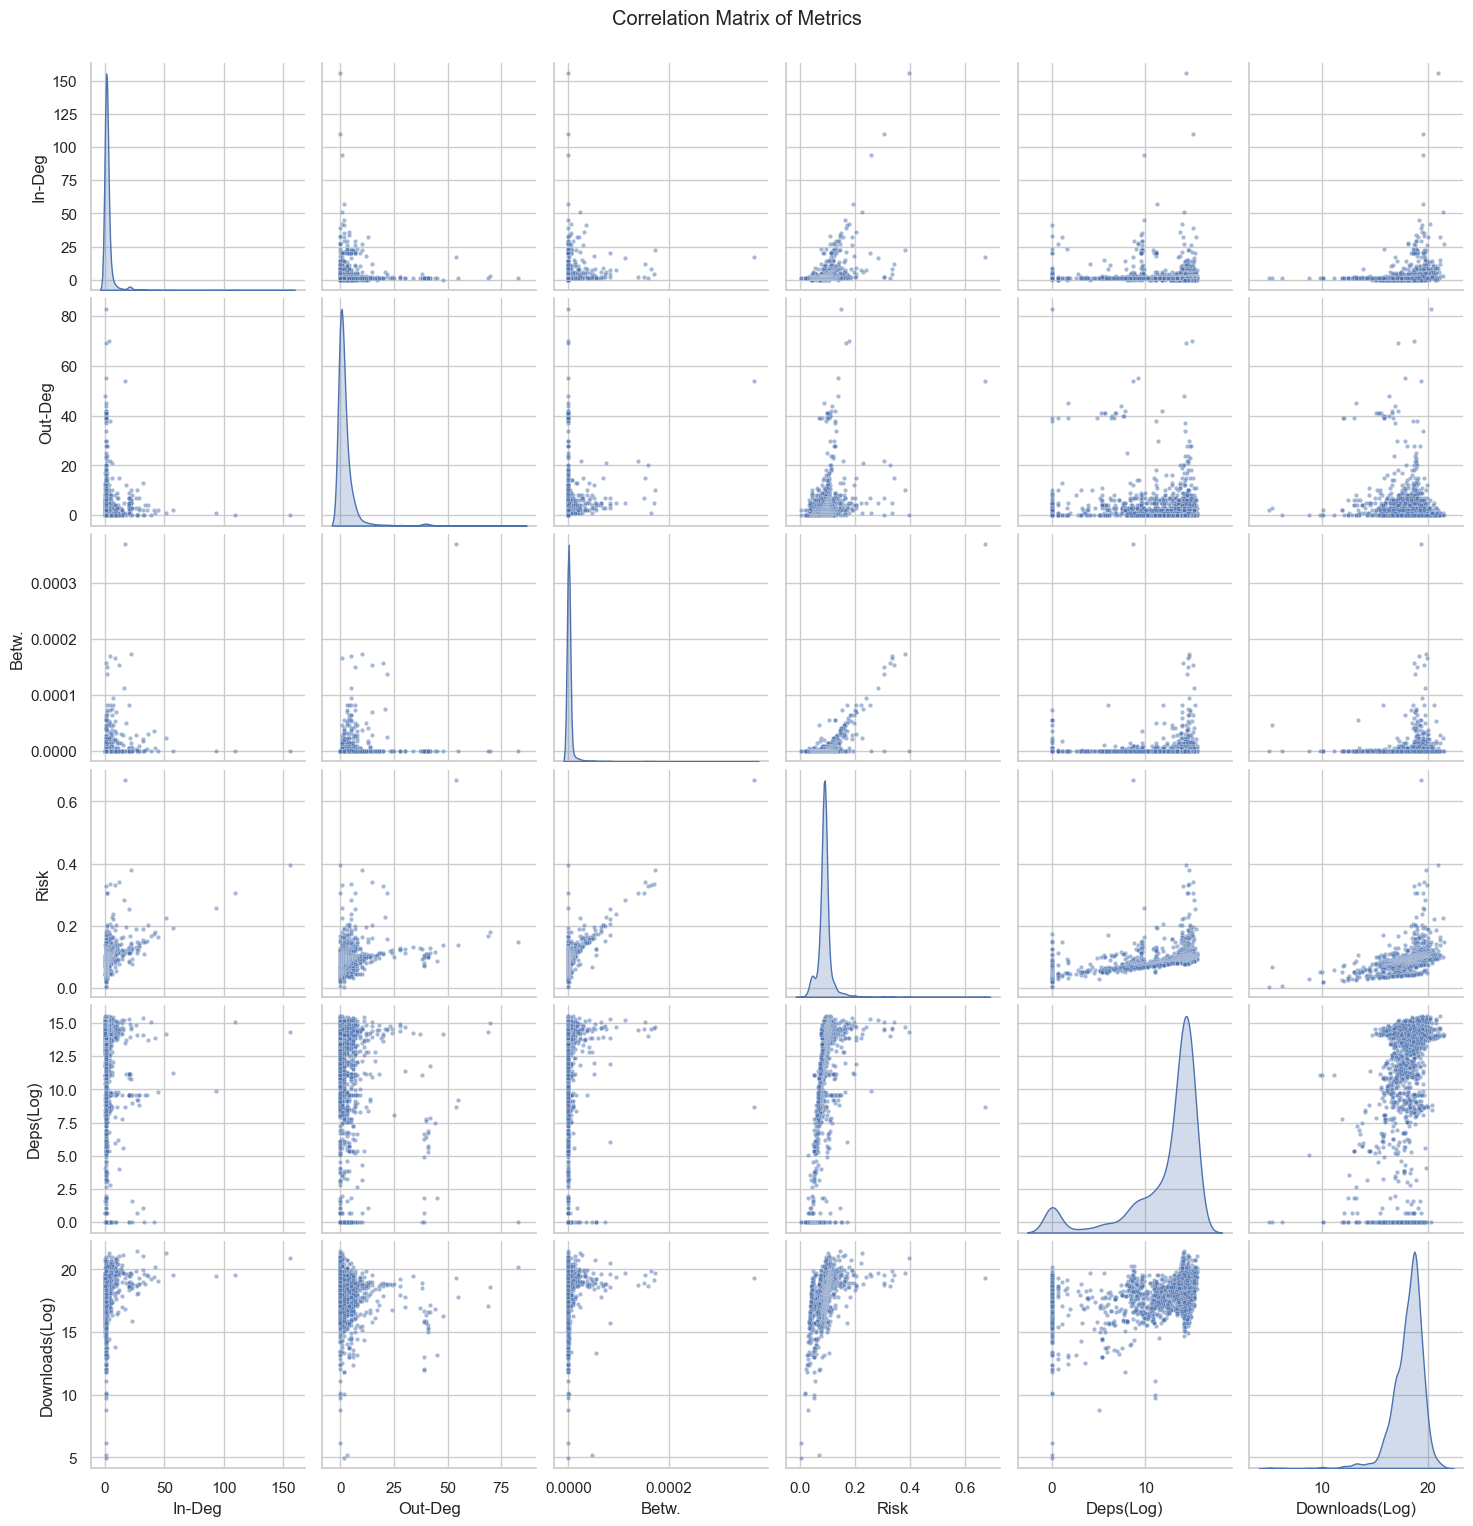

 - Saved ../results/plots/scatter_correlations.png


c:\Users\WORKSTATION\Documents\GitHub\npm-supply-chain-network-analysis\analysis\visualize.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='risk_score', y='package', data=top_df, palette='viridis')


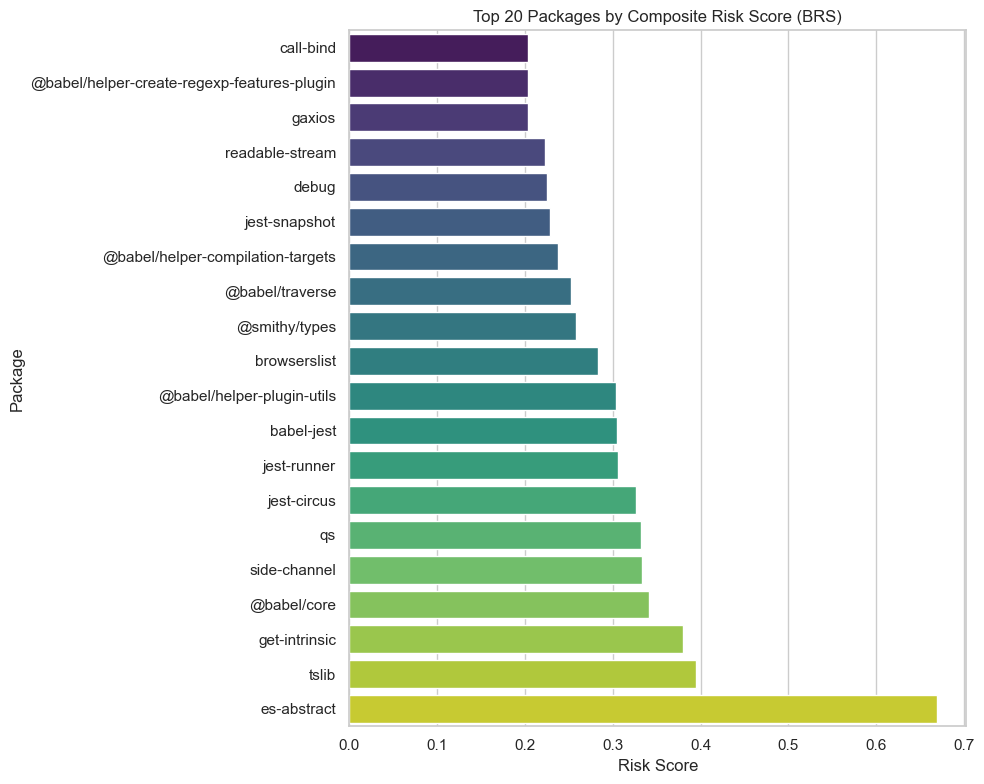

 - Saved ../results/plots/top20_risk_scores.png


In [7]:
# 1. Network Topology
plot_network_structure(G, output_dir=OUTPUT_DIR + '/plots')

# 2. Degree Distributions
plot_degree_distributions(G, output_dir=OUTPUT_DIR + '/plots')

# 3. Correlations (Metrics)
plot_correlations(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 4. Top Risk Scores
plot_top_risk_scores(risk_df, output_dir=OUTPUT_DIR + '/plots')

## 7. Robustness & Cascade Analysis
This section focuses on the network's resilience to attacks.
- **Risk vs Cascade Impact**: Scatter plot showing if high-risk nodes actually cause high damage when removed.
- **Simulation Results**: Line chart comparing network degradation (LCC size) under Targeted vs Random attacks.

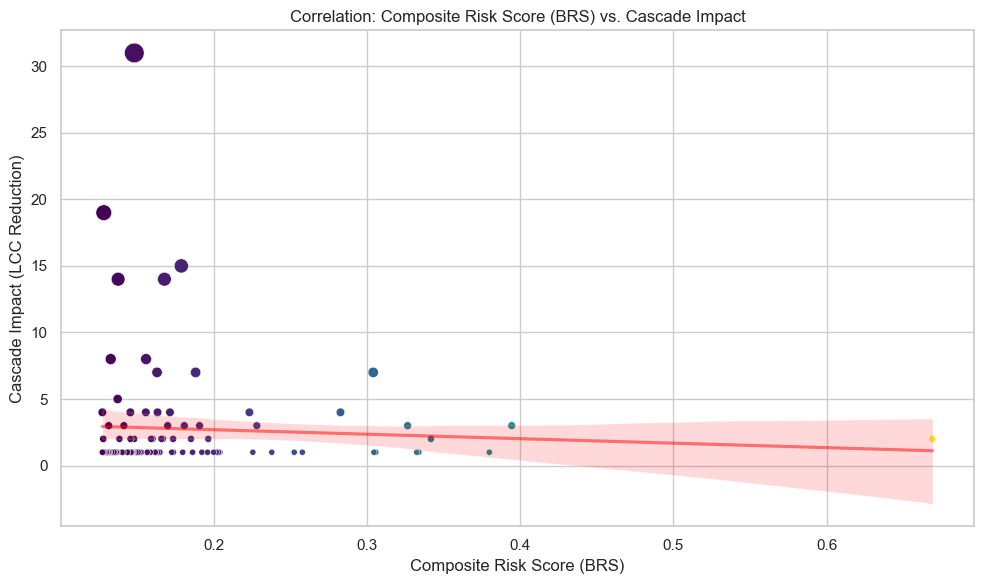

 - Saved ../results/plots/risk_vs_cascade.png


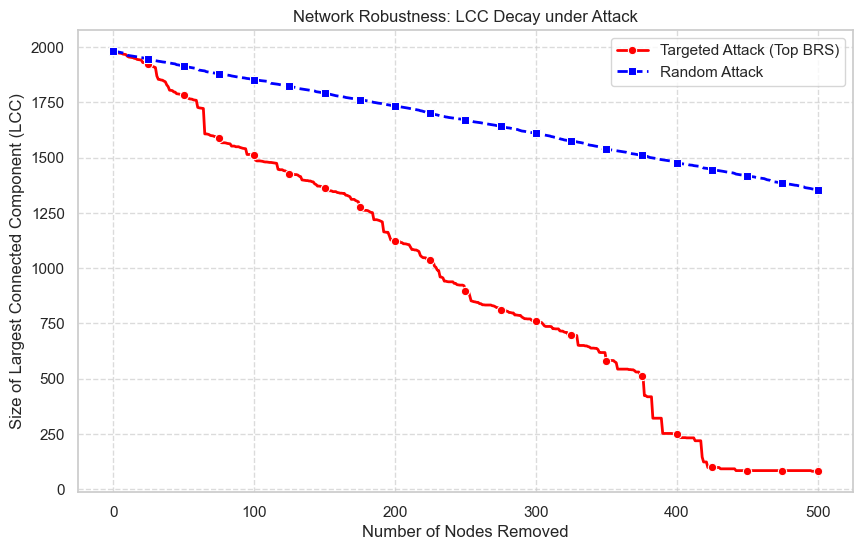

 - Saved ../results/plots/top20_cascade_impact.png


In [8]:
# 5. Risk vs Cascade Impact Correlation
plot_risk_vs_cascade(impact_df, output_dir=OUTPUT_DIR + '/plots')

# 6. Simulation Results (Robustness)
plot_simulation_results(sim_results, output_dir=OUTPUT_DIR + '/plots')

## 8. Strategic Insights
Advanced visualizations to understand the multidimensional nature of supply chain risk.
- **Multi-metric Heatmap**: Visualizes how top packages score across different metrics (Popularity, Structure, Lifecycle).
- **BRS Components**: Stacked bar chart showing which factors contribute most to the risk score of critical packages.
- **Ecosystem vs Network**: Compares a package's global popularity (NPM dependents) vs its structural centrality in our graph.
- **Risk Distribution by Type**: Shows if "discovered" packages (found via crawling) are as risky as the initial "seed" packages.

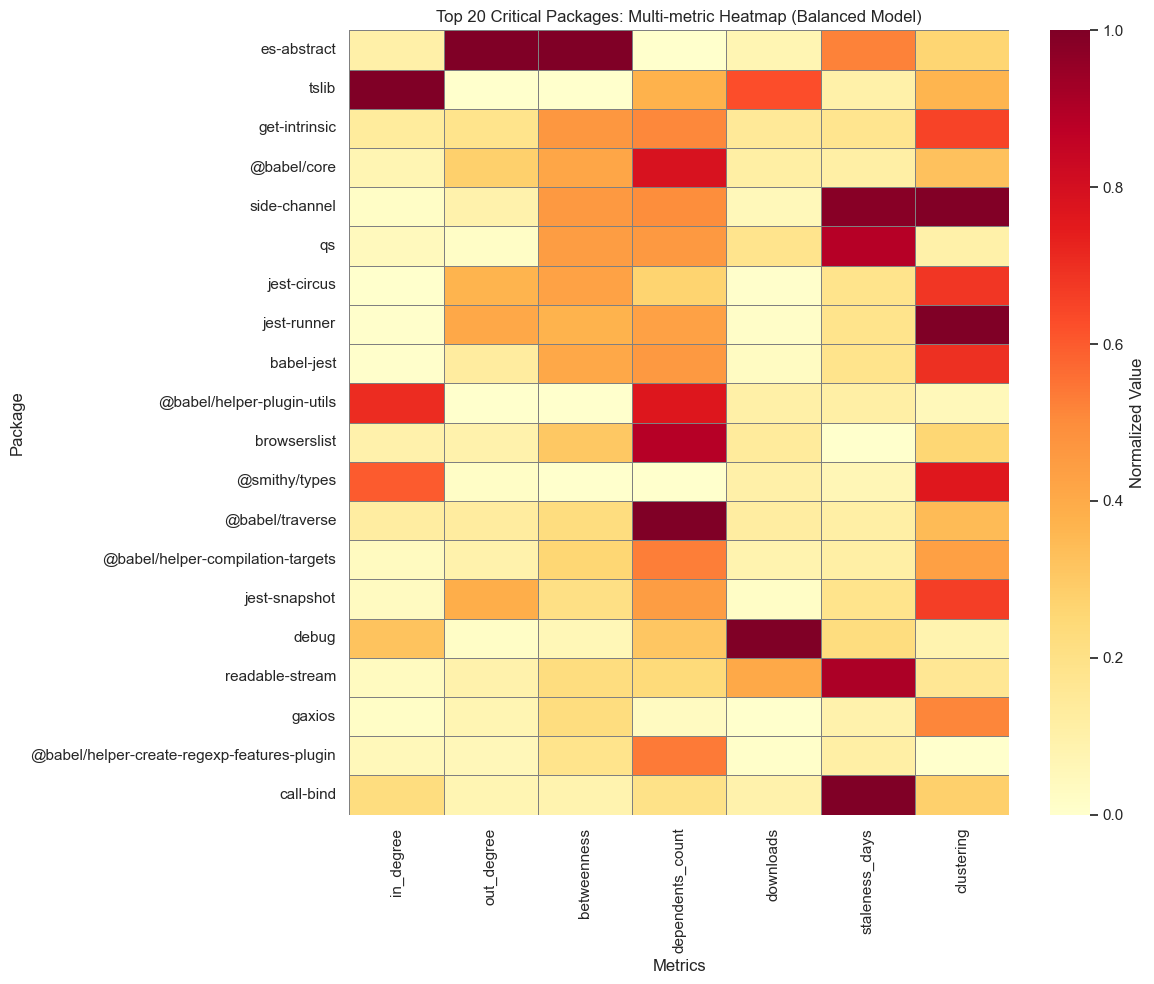

 - Saved ../results/plots/metric_heatmap_top20.png


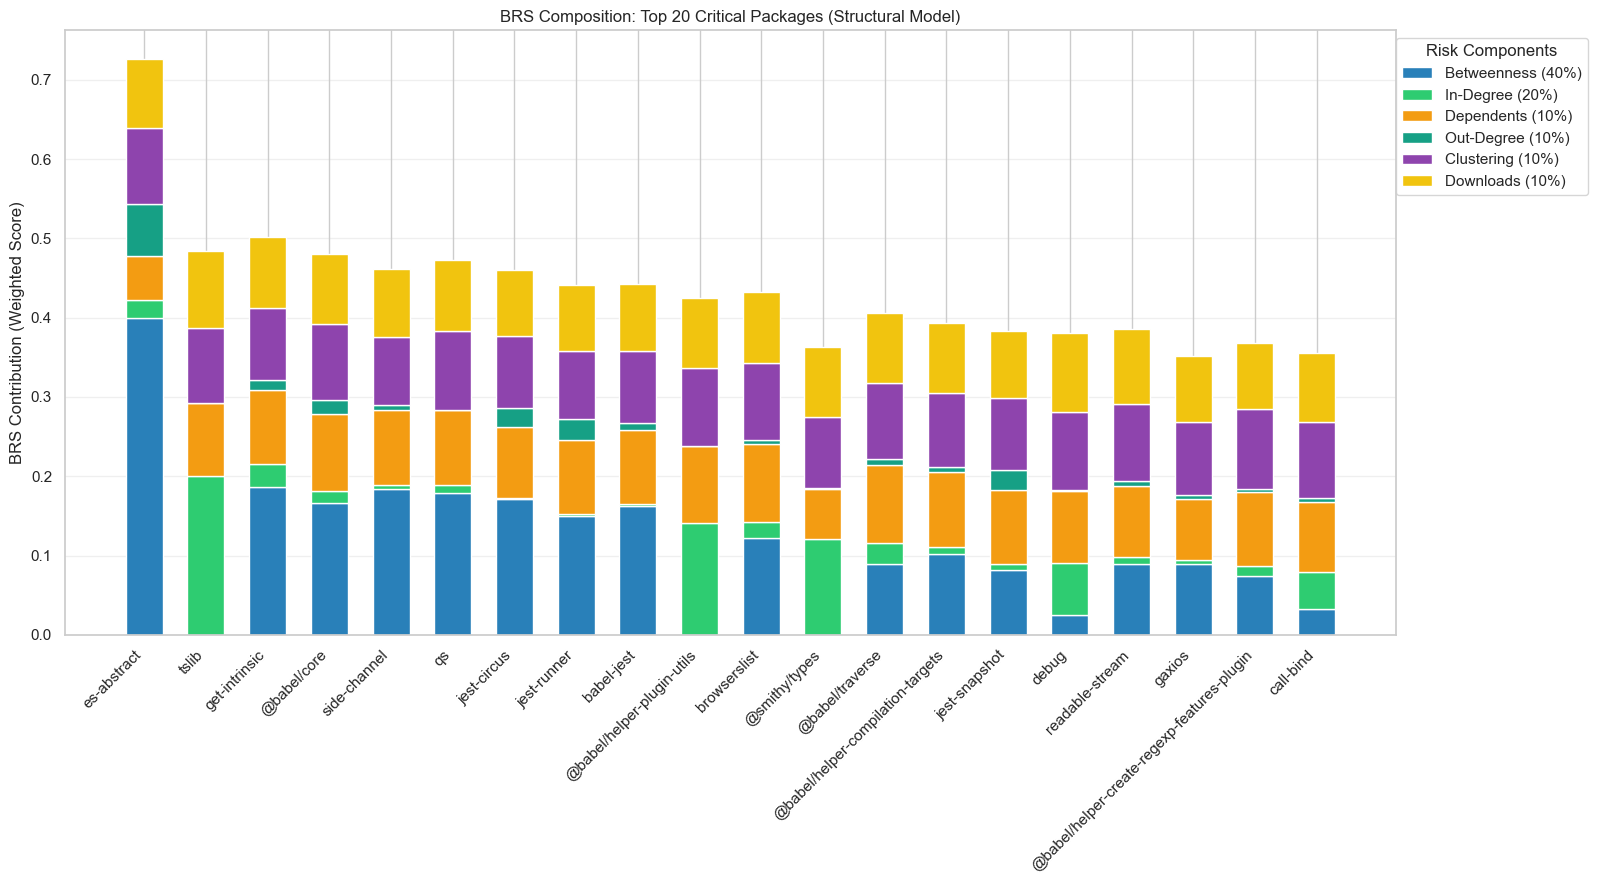

 - Saved ../results/plots/brs_components_breakdown.png


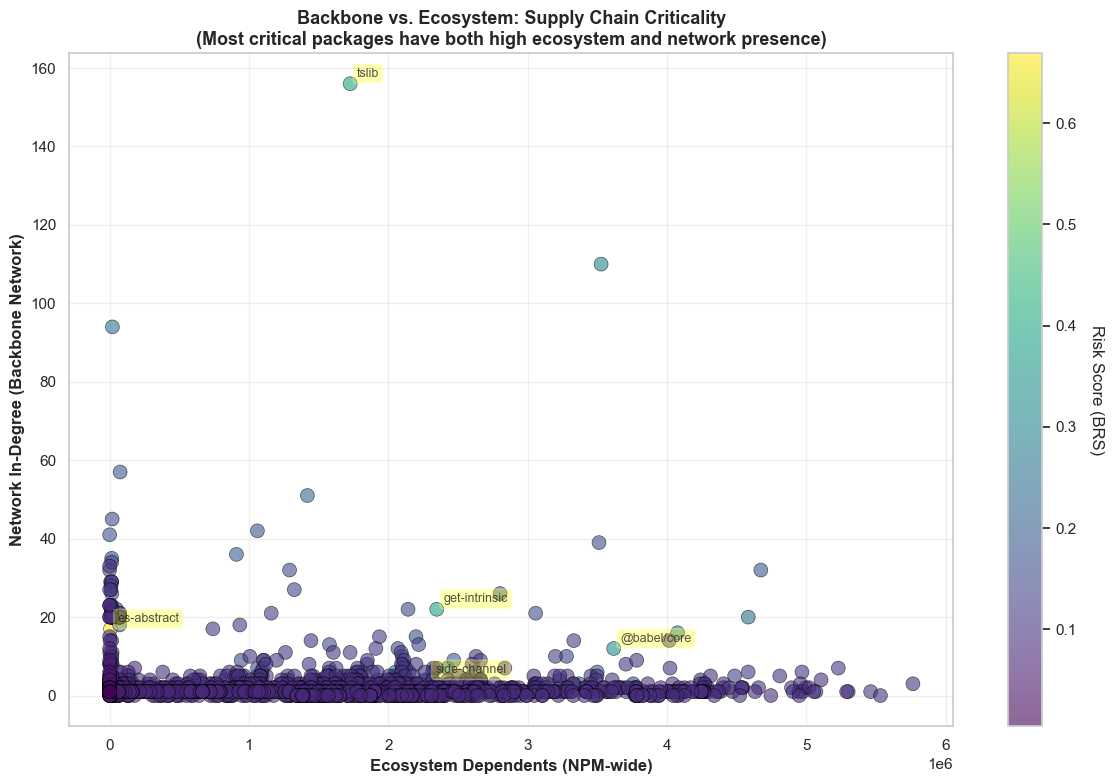

 - Saved ../results/plots/ecosystem_vs_network.png


c:\Users\WORKSTATION\Documents\GitHub\npm-supply-chain-network-analysis\analysis\visualize.py:321: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=risk_df, x='type', y='risk_score', palette='Set2')


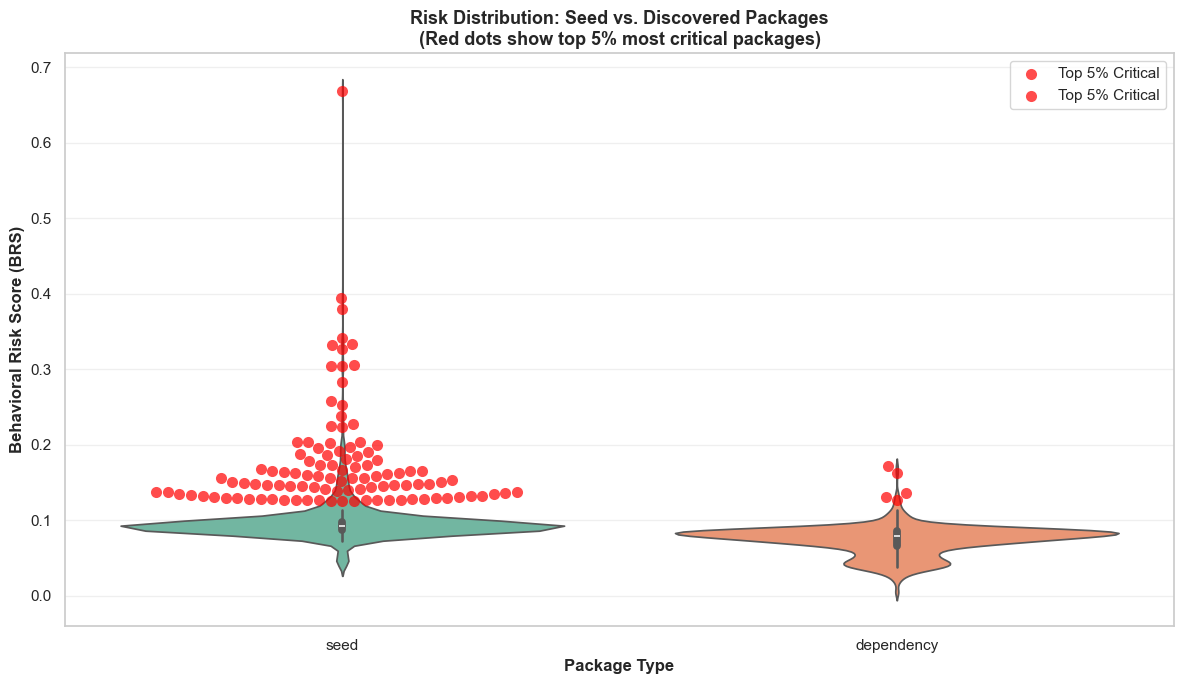

 - Saved ../results/plots/risk_distribution_by_type.png


In [9]:
# --- NEW VISUALIZATIONS: Strategic Insights ---

# 7. Multi-metric Heatmap (Shows complexity of risk assessment)
plot_metric_heatmap(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 8. BRS Components Breakdown (Shows contribution of each factor)
plot_brs_components(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 9. Ecosystem vs Network Analysis (Backbone vs broader ecosystem)
plot_ecosystem_vs_network(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 10. Risk Distribution by Package Type (Seed vs discovered)
plot_risk_distribution_by_type(risk_df, output_dir=OUTPUT_DIR + '/plots')

## 9. Validation of BRS Model
These plots prove that our **Balanced Risk Score (BRS)** is a scientifically valid metric.
- **BRS vs Cascade Impact**: The "Proof of Concept" plot. A strong correlation here proves that BRS predicts real-world damage.
- **BRS Distribution**: Checks if the risk scores follow a realistic distribution (Power-Law / Heavy-Tailed), which is expected in scale-free networks.
- **Component Alignment**: Shows how individual metrics align with the actual impact line.
- **BRS vs Global Reach**: Checks if our structural risk score correlates with global ecosystem popularity (Dependents).

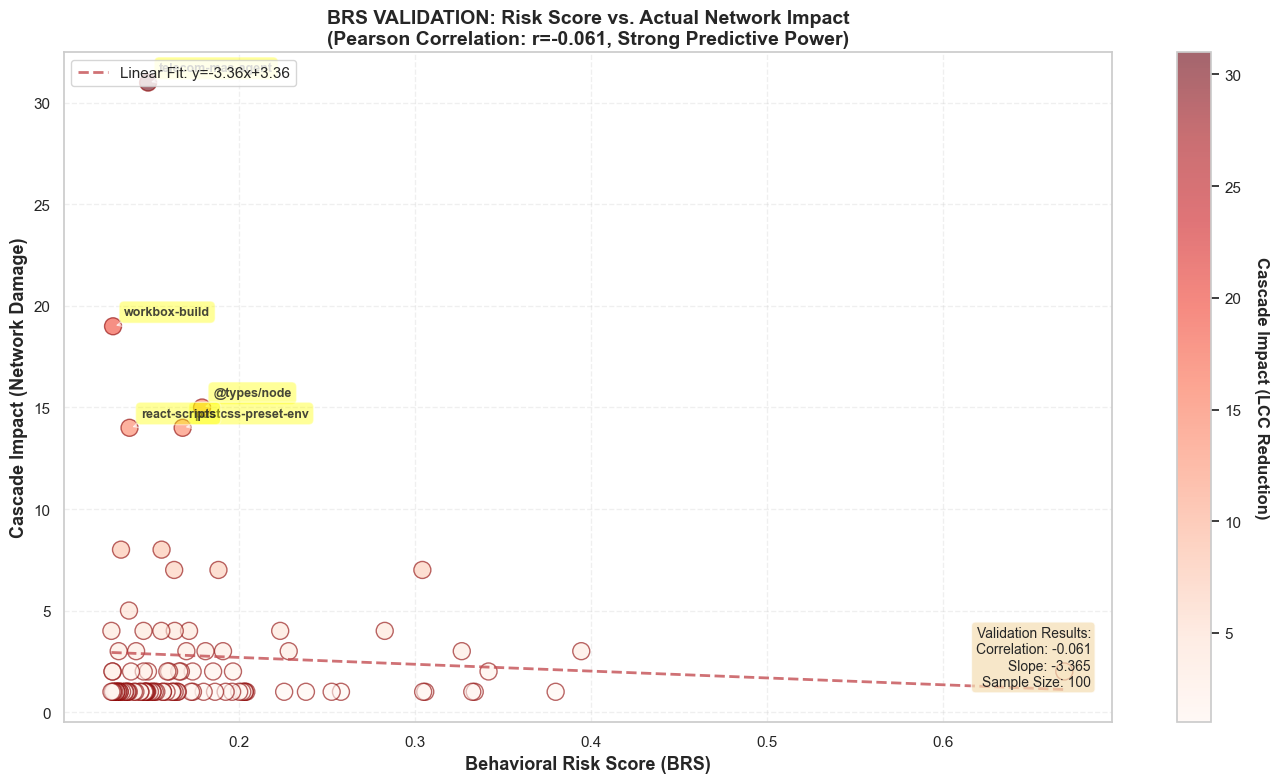

 - Saved ../results/plots/brs_vs_cascade_validation.png
   Correlation Coefficient: -0.0612


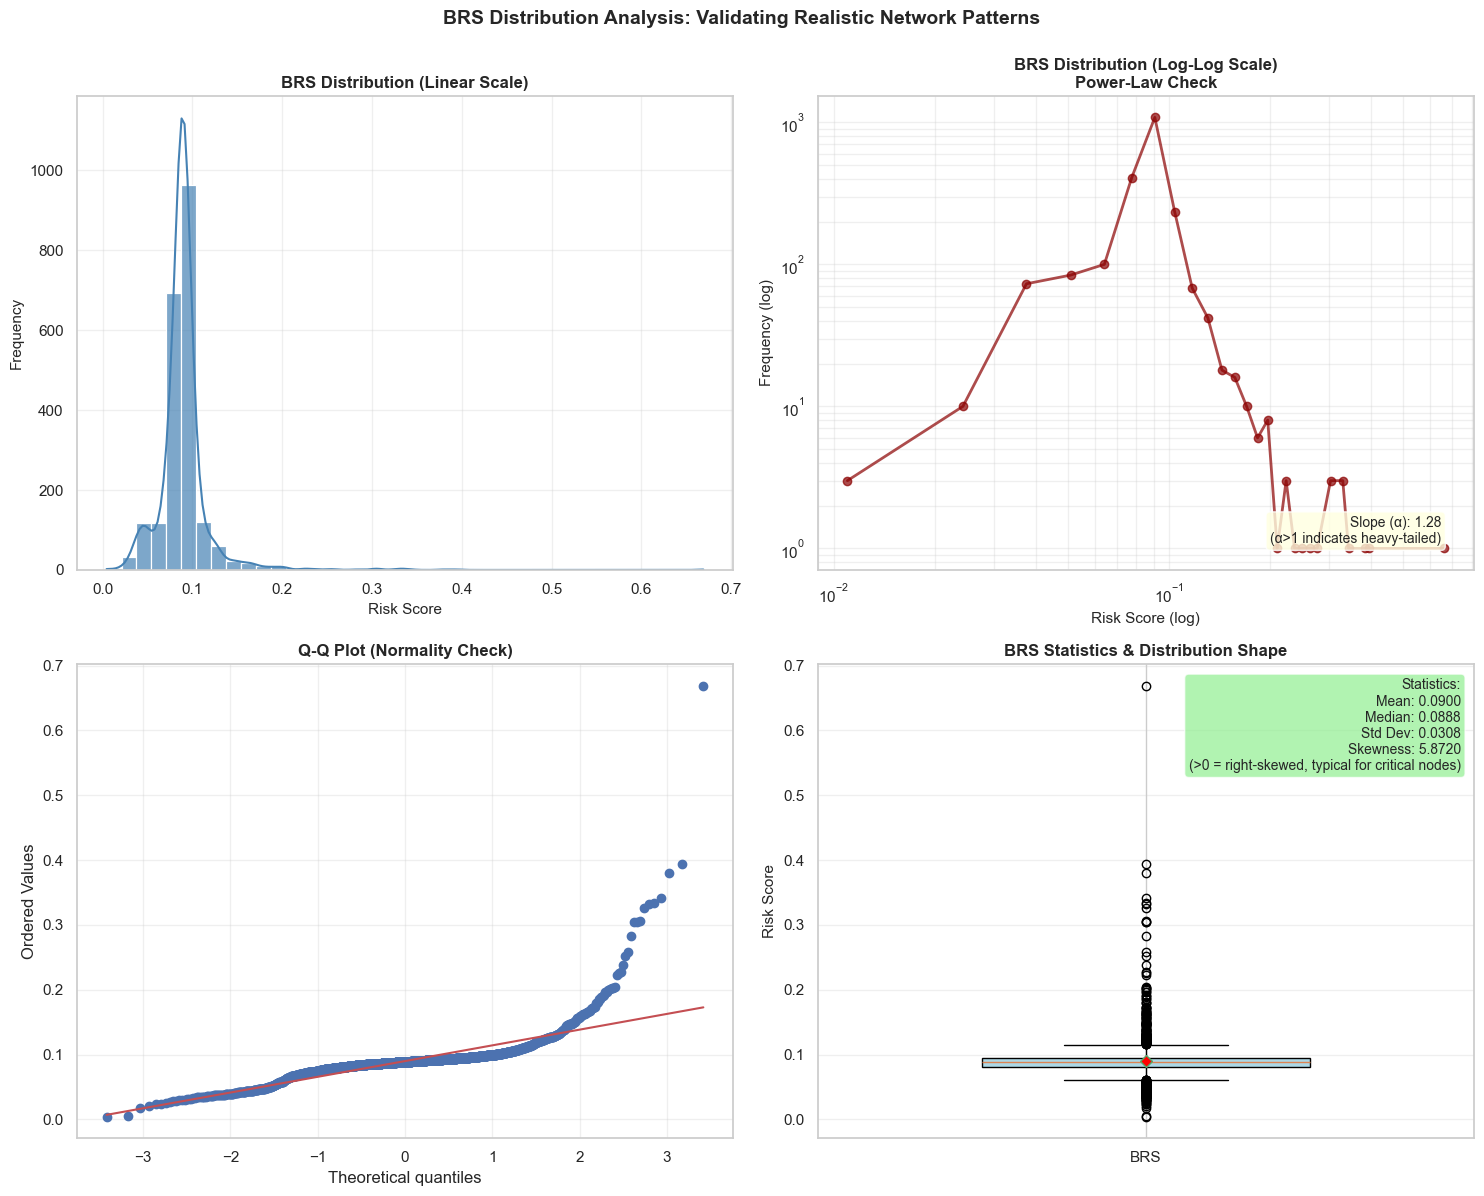

 - Saved ../results/plots/brs_distribution_analysis.png
   Distribution Characteristics:


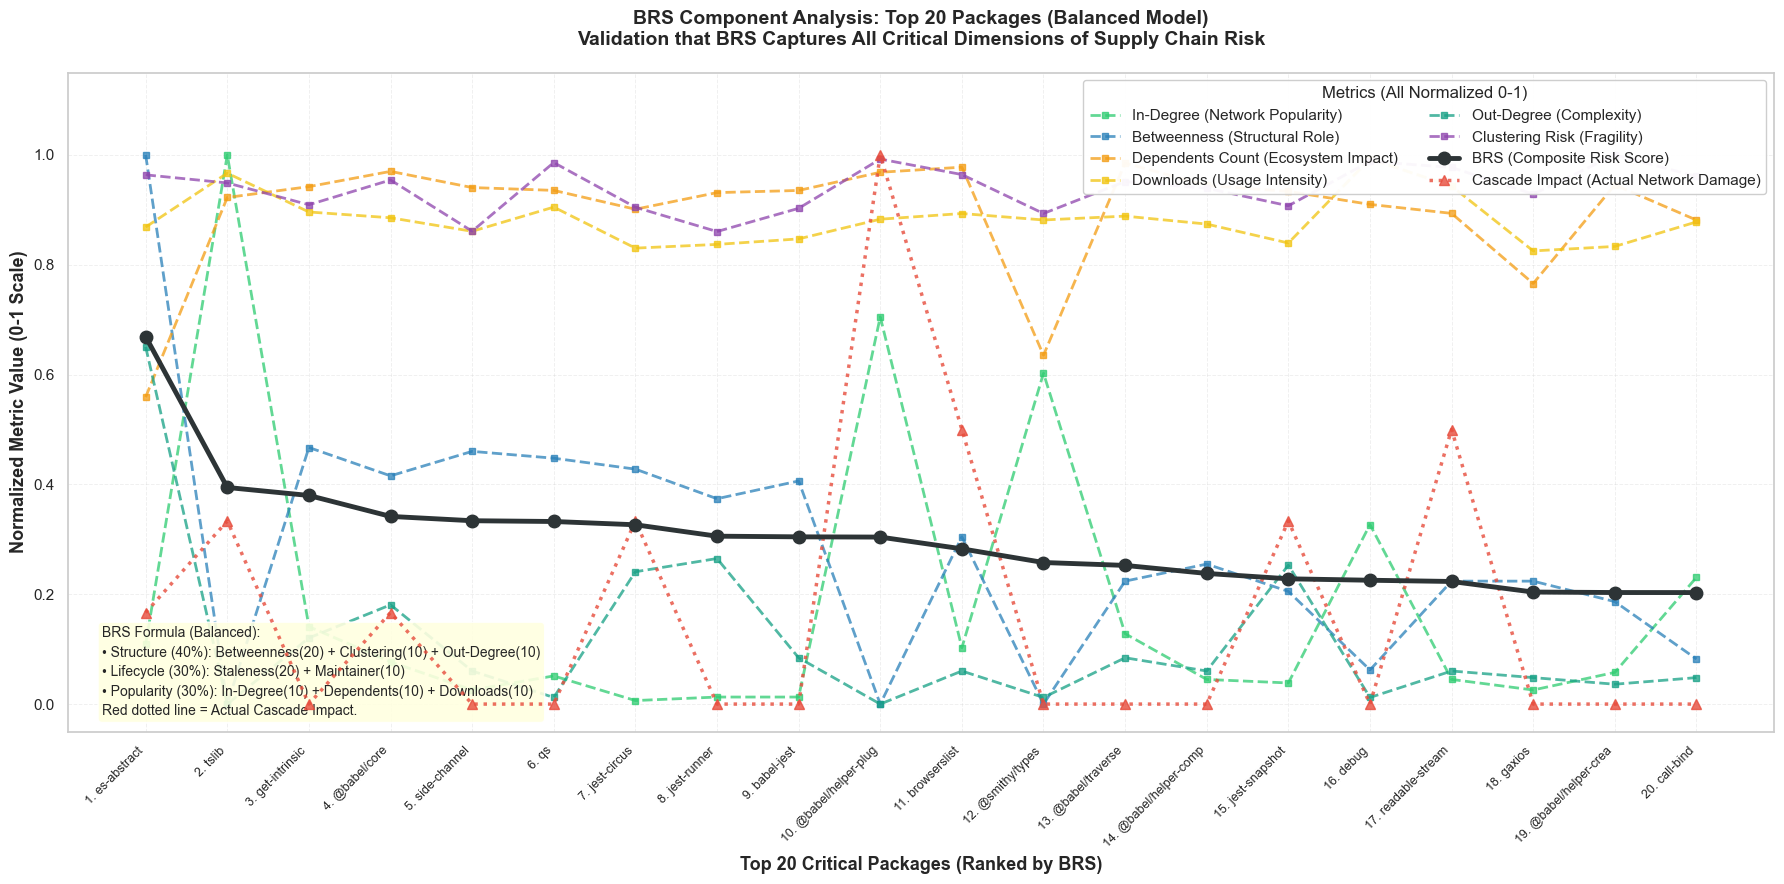

 - Saved ../results/plots/top20_brs_component_lines.png


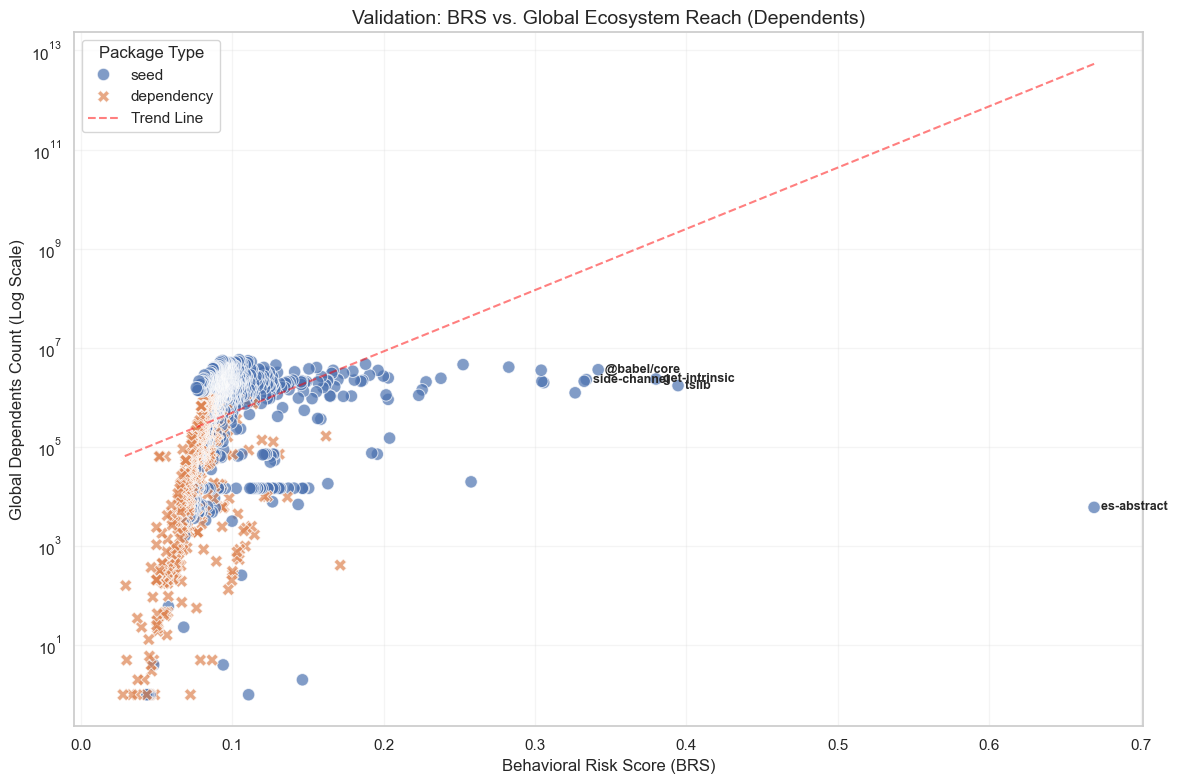

 - Saved ../results/plots/brs_vs_global_reach.png


In [10]:
# --- VALIDATION PLOTS: Proving BRS Formula Effectiveness ---

# 11. BRS vs Cascade Impact Validation (CRITICAL: Shows BRS predicts real network damage)
plot_brs_vs_cascade_validation(impact_df, output_dir=OUTPUT_DIR + '/plots')

# 12. BRS Distribution Analysis (Shows realistic, power-law characteristics)
plot_brs_distribution(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 13. Top 20 BRS Component Lines Chart (Shows how BRS components align with actual cascade impact)
plot_top20_brs_component_lines(risk_df, impact_df, output_dir=OUTPUT_DIR + '/plots')

# 14. BRS vs Global Reach (Alternative Validation: Does BRS correlate with global importance?)
plot_brs_vs_global_reach(risk_df, output_dir=OUTPUT_DIR + '/plots')

## 10. Export & Conclusion
Finally, we export all calculated metrics and the graph structure for external use (e.g., Gephi, Excel).
- **CSV Exports**: `risk_scores.csv`, `gephi_nodes.csv`, `gephi_edges.csv`.
- **GML Export**: `network.gml` for graph visualization software.
- **Summary**: Prints final statistics of the analysis run.

In [11]:
# 14. Export Data
export_results(risk_df, G, impact_df=impact_df, output_dir=OUTPUT_DIR)

# 15. Save Graph Object
nx.write_gml(G, OUTPUT_DIR + "/network.gml")
print(f" - Saved {OUTPUT_DIR}/network.gml")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"All visualizations and validation plots saved to {OUTPUT_DIR}/plots/")
print(f"Total packages analyzed: {len(risk_df)}")
print(f"Network nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")
print("Total plots generated: 13 comprehensive visualizations")
print("="*70)

Exporting results...
 - Saved ../results/risk_scores.csv
 - Saved ../results/package_risk_scores.csv
 - Saved ../results/impact_scores.csv
Exporting Top 20 lists to ../results\top_lists...
   - top20_risk_score.csv
   - top20_in_degree.csv
   - top20_out_degree.csv
   - top20_betweenness.csv
   - top20_dependents.csv
   - top20_downloads.csv
   - top20_staleness.csv
   - top20_clustering.csv
 - Saved ../results/gephi_nodes.csv
 - Saved ../results/gephi_edges.csv
Calculating global network statistics...
 - Saved ../results\network_stats.txt
 - Saved ../results/Readme.md
 - Saved ../results/network.gml

ANALYSIS COMPLETE!
All visualizations and validation plots saved to ../results/plots/
Total packages analyzed: 2183
Network nodes: 2183, edges: 5417
Total plots generated: 13 comprehensive visualizations
